In [22]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats 
import seaborn as sns
import statsmodels.formula.api as smf

In [23]:
plt.rc("font", size=14)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


from matplotlib.colors import BoundaryNorm, ListedColormap


In [24]:
input_f = 'limesurvey_feature_results_w_dims_uus.csv'

data = []

with open(input_f, 'r') as fid:
    csv_reader = csv.DictReader(fid, delimiter=',')
    fieldnames = csv_reader.fieldnames
    for line in csv_reader:
        data.append(line)

In [25]:
initial_df = pd.DataFrame(data).iloc[:, 1:].astype(float)

In [26]:
initial_df

,abs,afek,aeg,arg,form,imp,info,inst,inter,keer,...,appos,nummod,amod,advcl,voc,cop,conj,cc,yneemid,emoticons
0,1.35,0.85,0.65,1.55,0.70,1.80,1.10,0.90,0.45,0.50,...,0.000000,0.041916,0.029940,0.0,0.035928,0.095808,0.047904,0.0,0.0,0.005988
1,0.65,1.15,0.70,0.65,0.45,0.65,1.15,0.75,0.70,0.65,...,0.020134,0.067114,0.023490,0.0,0.033557,0.033557,0.030201,0.0,0.0,0.003356
2,1.25,1.65,0.15,1.50,0.15,0.55,0.35,0.60,0.85,0.40,...,0.004329,0.034632,0.038961,0.0,0.012987,0.038961,0.038961,0.0,0.0,0.004329
3,0.60,1.20,0.80,1.85,0.45,1.15,0.65,0.30,0.45,0.05,...,0.020979,0.083916,0.034965,0.0,0.013986,0.034965,0.027972,0.0,0.0,0.006993
4,1.15,0.80,0.40,1.40,0.70,0.75,0.85,0.25,0.20,0.55,...,0.000000,0.059783,0.016304,0.0,0.021739,0.048913,0.032609,0.0,0.0,0.005435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.35,1.25,2.10,0.65,0.15,0.90,0.70,0.75,1.70,0.25,...,0.000000,0.040323,0.010753,0.0,0.024194,0.043011,0.043011,0.0,0.0,0.002688
116,0.50,1.40,0.60,1.50,0.55,0.85,1.20,0.40,0.55,0.10,...,0.025478,0.044586,0.038217,0.0,0.025478,0.025478,0.025478,0.0,0.0,0.006369
117,0.10,0.80,2.60,0.55,0.85,0.95,2.10,0.80,0.65,1.00,...,0.028000,0.044000,0.000000,0.0,0.012000,0.068000,0.040000,0.0,0.0,0.004000
118,0.40,0.60,0.35,0.50,0.55,1.60,1.85,2.65,0.70,0.25,...,0.035088,0.017544,0.000000,0.0,0.017544,0.105263,0.061404,0.0,0.0,0.008772


In [27]:
feature_names = initial_df.columns[12:]

In [28]:
def save_csv(prefix, df):
    df.to_csv(f'korrelatsiooni_csvd/{prefix}.csv')

In [29]:
def plot_important_features(model, dimname):
    
    print(model.coef_)

    feature_importance = abs(model.coef_[0])
    
    
    feature_importance = 1.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(15,20))
    featax = featfig.add_subplot(1, 1, 1)

    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
    featax.set_xlabel(f'Relative Feature Importance {str.upper(dimname)}')

    # plt.tight_layout()   
    plt.show()

In [30]:
def get_corr_pairs(corr_df):

    columns = [line for line in corr_df]
    matches = []

    for column, rows in corr_df.items():
        for m, score in rows.items():
            if (score > 0.75 or score < -0.75) and column != m:
                matches.append([(column, m), score])
            continue

    without_duplicates = []
    for ws, i in matches:
        ls = (sorted(ws), i)
        if ls not in without_duplicates:
            without_duplicates.append(ls)       

    return without_duplicates

In [31]:
def generate_heatmap(dim, corr_data):

    my_colors = ['black', 'lightgrey', 'white', 'red']
    my_cmap = ListedColormap(my_colors)
    bounds = [-1.0, -0.75, 0.75, 1.0]
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))



    mask = np.triu(np.ones_like(corr_data))

    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    hmap = sns.heatmap(corr_data,
                yticklabels=1, 
                ax=ax,
                linewidths=1.0,
                cmap=my_cmap,
                norm=my_norm,
                mask=mask,
               cbar_kws = dict(use_gridspec=False,location="top")
               )

    colorbar = ax.collections[0].colorbar
    hmap.figure.savefig(f'heatmapid/{dim}_heatmap.png', format='png', dpi=150)
    plt.show()


In [32]:
all_df = initial_df.iloc[:, 12:]
all_corr = all_df.corr(method='pearson').round(2)

# save_csv('dimensions', all_corr)

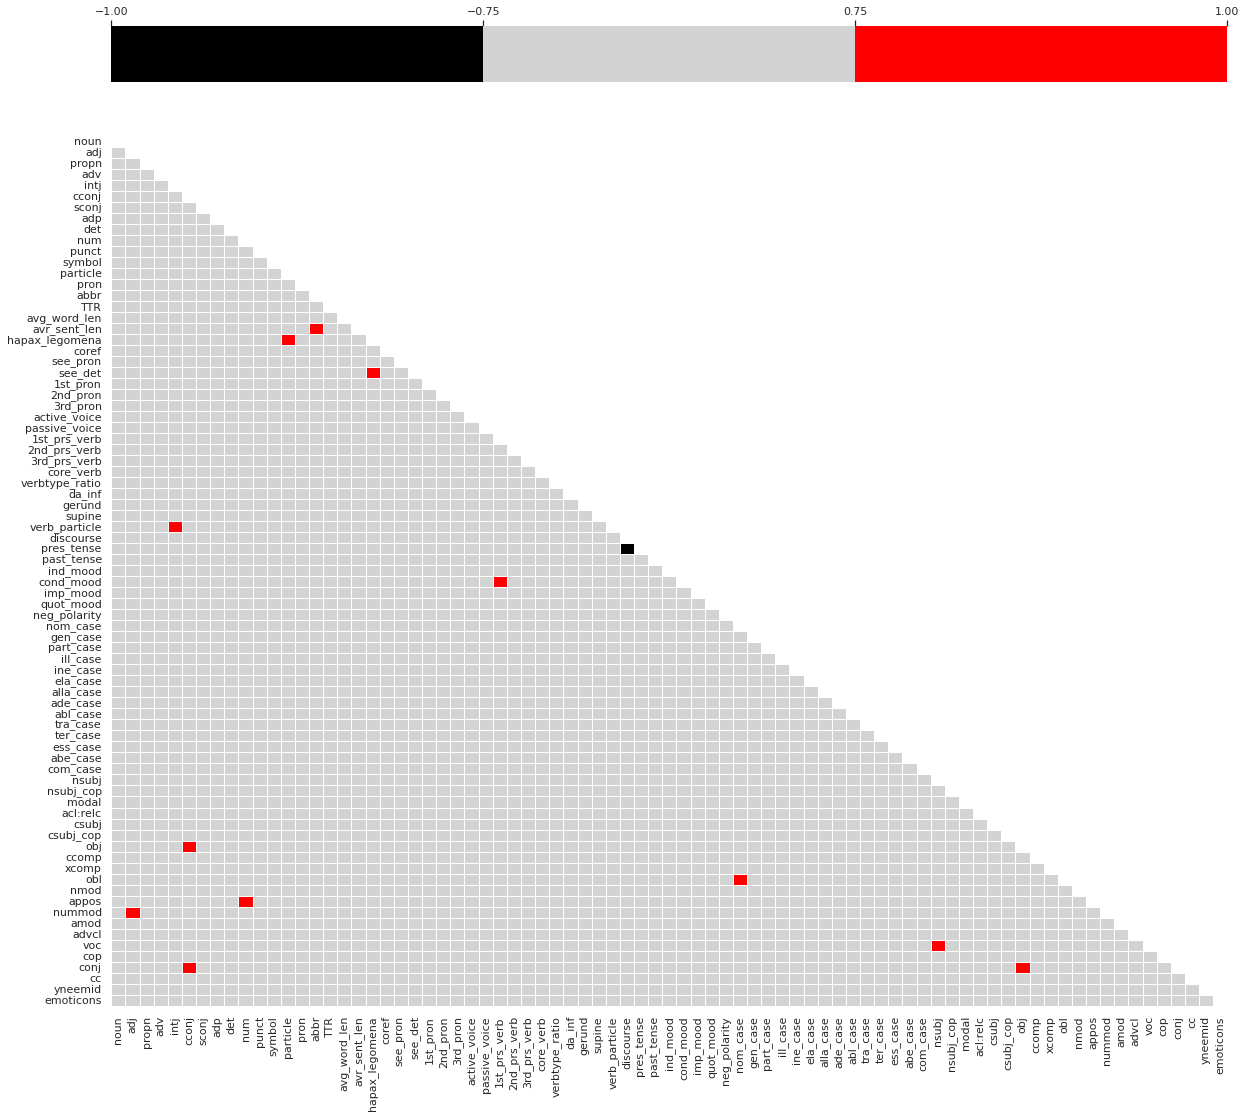

In [33]:
generate_heatmap('all_dims', all_corr)

In [34]:
pairs = get_corr_pairs(all_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

['adj', 'nummod'] = 0.76
['intj', 'verb_particle'] = 1.0
['cconj', 'obj'] = 0.93
['cconj', 'conj'] = 1.0
['appos', 'num'] = 0.88
['hapax_legomena', 'particle'] = 0.91
['abbr', 'avr_sent_len'] = 0.83
['hapax_legomena', 'see_det'] = 0.78
['1st_prs_verb', 'cond_mood'] = 0.98
['discourse', 'pres_tense'] = -0.77
['nom_case', 'obl'] = 0.86
['nsubj', 'voc'] = 0.9
['conj', 'obj'] = 0.93


# eelmised, koos +1 lisamisega tunnusele

['adj', 'amod'] = 0.78

['discourse', 'intj'] = 1.0

['intj', 'voc'] = 0.76

['ccomp', 'cconj'] = 0.93

['cc', 'cconj'] = 1.0

['num', 'nummod'] = 0.88

['coref', 'pron'] = 0.91

['TTR', 'hapax_legomena'] = 0.83

['2nd_prs_verb', 'imp_mood'] = 0.98

['discourse', 'voc'] = 0.76

['past_tense', 'pres_tense'] = -0.77

['quot_mood', 'voc'] = 0.88

['quot_mood', 'yneemid'] = 0.78

['emoticons', 'quot_mood'] = 0.87

['gen_case', 'nmod'] = 0.86

['cop', 'nsubj_cop'] = 0.9

['cc', 'ccomp'] = 0.93

['voc', 'yneemid'] = 0.86

['emoticons', 'voc'] = 0.96

['emoticons', 'yneemid'] = 0.85

In [ ]:
def make_new_df(dim_name):
    positive = initial_df.loc[initial_df[dim_name]>=2, initial_df.columns[12:]]
    negative = initial_df.loc[initial_df[dim_name]<2, initial_df.columns[12:]]
    return positive, negative



## dimensioonide ja tekstide jaotumine hinnangute järgi

In [35]:
import os

originaalsed_vastused = '../dimensioonide_originaalsed_hinnangud'
dir_list = os.listdir(originaalsed_vastused)

files = [os.path.join(originaalsed_vastused, x) for x in dir_list if x.endswith('.csv')]

In [50]:
from prettytable import PrettyTable


for f in files:
    with open(f, 'r') as fid:
        print(os.path.basename(f))

        csv_reader = csv.reader(fid)
        data = [line for line in csv_reader]
        data_df = pd.DataFrame(data).replace(r'^\s*$', 0, regex=True)
        summed_df = data_df.iloc[:, 1:].astype('float').sum(axis=1)/10
        tugev, moodukas, nork, puuduv = 0, 0, 0, 0
        for score in summed_df:
            if score >= 3:
                tugev += 1
            elif score >= 2 and score < 3:
                moodukas += 1
            elif score >= 1 and score < 2:
                nork += 1
            else:
                puuduv += 1
        t = PrettyTable(['Hinnang ', 'Tekstide arv'])
        t.add_row(['Tugev (hinnang = 3)', tugev])
        t.add_row(['Mõõdukas (hinnang <3 ja >= 2)', moodukas])
        t.add_row(['Nõrk (hinnang <2 ja >= 1)', nork])
        t.add_row(['Puudub (ehk <1)', puuduv])
        print(f'{t}\n')



subj.csv
+-------------------------------+--------------+
|            Hinnang            | Tekstide arv |
+-------------------------------+--------------+
|      Tugev (hinnang = 3)      |      1       |
| Mõõdukas (hinnang <3 ja >= 2) |      16      |
|   Nõrk (hinnang <2 ja >= 1)   |      22      |
|        Puudub (ehk <1)        |      81      |
+-------------------------------+--------------+

inst.csv
+-------------------------------+--------------+
|            Hinnang            | Tekstide arv |
+-------------------------------+--------------+
|      Tugev (hinnang = 3)      |      0       |
| Mõõdukas (hinnang <3 ja >= 2) |      12      |
|   Nõrk (hinnang <2 ja >= 1)   |      18      |
|        Puudub (ehk <1)        |      90      |
+-------------------------------+--------------+

imp.csv
+-------------------------------+--------------+
|            Hinnang            | Tekstide arv |
+-------------------------------+--------------+
|      Tugev (hinnang = 3)      |      0 

In [43]:
dims = ['subj', 'inst', 'imp', 'arg', 'afek', 'keer', 'inter', 'form', 'abs', 'spont', 'aeg', 'info']

In [62]:
for dim in dims:
    print(dim)
    df = initial_df[dim]
    tugev, moodukas, nork, puuduv = 0, 0, 0, 0
    # print(df)
    for score in df:
        if score >= 3.0:
            tugev += 1
        elif score >= 2 and score < 3.0:
            moodukas += 1
        elif score >= 1 and score < 2.0:
            nork += 1
        else:
            puuduv += 1
    t = PrettyTable(['Hinnang ', 'Tekstide arv'])
    t.add_row(['Tugev (hinnang = 3)', tugev])
    t.add_row(['Mõõdukas (hinnang <3 ja >= 2)', moodukas])
    t.add_row(['Nõrk (hinnang <2 ja >= 1)', nork])
    t.add_row(['Puudub (ehk <1)', puuduv])
    print(f'{t}\n')

subj
+-------------------------------+--------------+
|            Hinnang            | Tekstide arv |
+-------------------------------+--------------+
|      Tugev (hinnang = 3)      |      1       |
| Mõõdukas (hinnang <3 ja >= 2) |      20      |
|   Nõrk (hinnang <2 ja >= 1)   |      28      |
|        Puudub (ehk <1)        |      71      |
+-------------------------------+--------------+

inst
+-------------------------------+--------------+
|            Hinnang            | Tekstide arv |
+-------------------------------+--------------+
|      Tugev (hinnang = 3)      |      0       |
| Mõõdukas (hinnang <3 ja >= 2) |      12      |
|   Nõrk (hinnang <2 ja >= 1)   |      22      |
|        Puudub (ehk <1)        |      86      |
+-------------------------------+--------------+

imp
+-------------------------------+--------------+
|            Hinnang            | Tekstide arv |
+-------------------------------+--------------+
|      Tugev (hinnang = 3)      |      0       |
| Mõ

## ABSTRAKTNE

In [39]:
abs_df = initial_df['abs']
abs_df
# initial_df[initial_df['abs']<=1]

0      1.35
1      0.65
2      1.25
3      0.60
4      1.15
       ... 
115    0.35
116    0.50
117    0.10
118    0.40
119    1.05
Name: abs, Length: 120, dtype: float64

In [ ]:
pos, neg = make_new_df('abs')

print(len(pos), len(neg))

In [ ]:
pos

In [ ]:
abs_corr = pos.corr(method='pearson').round(2)
save_csv('abs', abs_corr)
abs_corr


In [ ]:
generate_heatmap('abs', abs_corr)

In [ ]:
pairs = get_corr_pairs(abs_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


### NORMAALJAOTUS

In [ ]:
def generate_plot(dim, df1, df2, features):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 200))
    plt.subplots_adjust(hspace=0.5)

    for i, feature in enumerate(features):
        df1_mean = np.mean(df1[str(feature)])
        df1_std = np.std(df1[str(feature)])
        pdf1 = stats.norm.pdf(df1[str(feature)].sort_values(), df1_mean, df1_std)
        
        df2_mean = np.mean(df2[str(feature)])
        df2_std = np.std(df2[str(feature)])
        pdf2 = stats.norm.pdf(df2[str(feature)].sort_values(), df2_mean, df2_std)
    
        ax = plt.subplot(40, 2, i+1)
        plt.plot(df1[str(feature)].sort_values(), pdf1, label='>=2')
        plt.plot(df2[str(feature)].sort_values(), pdf2, label='<2')
        plt.legend(loc=1, prop={'size': 20})
        plt.xlabel(str(feature.upper()))

#         plt.savefig(f'normdist_plots/{dim}.pdf')

In [ ]:
generate_plot('abs', pos, neg, feature_names)

### LOGISTILINE REGRESSIOON

In [ ]:
feats = [*feature_names]

In [ ]:
only_abs = initial_df.loc[:, feats + ['abs']].astype('float64')
only_abs['state'] = [1 if score >= 1 else 0 for score in only_abs['abs']]
# print(only_abs)

final_features = only_abs.columns.values.tolist()[:-2]


X = only_abs[final_features]
y = only_abs.state

model = LogisticRegression().fit(X,y)

plot_important_features(model, 'abstraktsus')


In [ ]:

log_reg = smf.logit("state ~ coref + hapax_legomena + noun + nom_case + avg_word_len + past_tense + pres_tense + obl + adv + num + ade_case + nummod + part_case", data=only_abs).fit()
log_reg.summary()

# AFEKTIIVNE

In [ ]:
dim = 'afek'

In [ ]:
pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:


dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['afek']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['afek']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'afektiivsus')

In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + noun + adv + pron + verbtype_ratio + TTR + punct + active_voice + adj + conj + avr_sent_len", data=df).fit()
log_reg.summary()

## AEG

In [ ]:
dim = 'aeg'
pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)

pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)


In [ ]:
df = initial_df.loc[:, feats + ['aeg']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['aeg']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'aeg')

In [ ]:
log_reg = smf.logit("state ~ coref + past_tense + pres_tense + obl + verbtype_ratio + adv + num + avg_word_len + gen_case + nummod + noun + core_verb + ade_case + propn + da_inf + cop", data=df).fit()
log_reg.summary()

## ARGUMENTATIIVNE

In [ ]:
dim = 'arg'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['arg']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['arg']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'arg')



In [ ]:
log_reg = smf.logit("state ~ coref + hapax_legomena + propn + verbtype_ratio + past_tense + pres_tense + avg_word_len + gen_case + conj + TTR + adj + neg_polarity + obl + part_case", data=df).fit()
log_reg.summary()

## FORMAALNE

In [ ]:
dim = 'form'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)

pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['form']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['form']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'formaalsus')




In [ ]:

log_reg = smf.logit("state ~ avg_word_len + coref + gen_case + noun + obl + adv + nmod + num", data=df).fit()
log_reg.summary()

## IMPERSONAALNE

In [ ]:
dim = 'imp'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['imp']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['imp']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'impersonaalsus')





In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + noun + past_tense + pres_tense + conj + pron + num", data=df).fit()
log_reg.summary()

## INFO

In [ ]:
dim = 'info'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['info']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['info']]

final_features = df.columns.values.tolist()[:-2]

X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'info')


In [ ]:

log_reg = smf.logit("state ~ coref + num + avg_word_len + active_voice + propn + nummod + pron + ind_mood + hapax_legomena + nsubj", data=df).fit()
log_reg.summary()

## INSTRUEERIV

In [ ]:
dim = 'inst'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['inst']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['inst']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'instrueerivus')


In [ ]:
log_reg = smf.logit("state ~ coref + pres_tense + nom_case + pron + hapax_legomena + past_tense + verbtype_ratio + noun + third_prs_verb + second_prs_verb + imp_mood + pron", data=df).fit()
log_reg.summary()

## INTERAKTIIVNE

In [ ]:
dim = 'inter'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')

generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['inter']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['inter']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'inter')

In [ ]:
log_reg = smf.logit("state ~ avg_word_len + hapax_legomena + TTR + gen_case + noun + verbtype_ratio + avr_sent_len", data=df).fit()
log_reg.summary()

## KEER

In [ ]:
dim = 'keer'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['keer']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['keer']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'keerulisus')

In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + hapax_legomena + verbtype_ratio + abbr + nmod + past_tense + obl + active_voice", data=df).fit()
log_reg.summary()

## SPONT

In [ ]:
dim = 'spont'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)

pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['spont']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['spont']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'spontaansus')





In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + noun + gen_case + nom_case + avr_sent_len + obl + propn", data=df).fit()
log_reg.summary()

## SUBJ

In [ ]:
dim = 'subj'

pos, neg = make_new_df(dim)
print(len(pos), len(neg))

In [ ]:
dim_df_corr = pos.corr(method='pearson').round(2)
save_csv(dim, dim_df_corr)

generate_heatmap(dim, dim_df_corr)


pairs = get_corr_pairs(dim_df_corr)
for pair in pairs:
    print(f'{pair[0]} = {pair[1]}')


generate_plot(dim, pos, neg, feature_names)

In [ ]:
df = initial_df.loc[:, feats + ['subj']].astype('float64')
df['state'] = [1 if score >= 1.5 else 0 for score in df['subj']]

final_features = df.columns.values.tolist()[:-2]


X = df[final_features]
y = df.state

model = LogisticRegression().fit(X,y)
plot_important_features(model, 'subjektiivsus')





In [ ]:
log_reg = smf.logit("state ~ avg_word_len + coref + verbtype_ratio + adv + propn + noun", data=df).fit()
log_reg.summary()